In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from tqdm import tqdm
#from tqdm.auto import tqdm
import pandas as pd
import os
import PIL
import skimage
from skimage import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
seed = 123
import cv2
torch.manual_seed(seed)
from collections import Counter
from time import sleep
import random
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
from google.colab.patches import cv2_imshow

In [1]:
"""Download Cat-Dog dataset"""
# !curl -L https://public.roboflow.com/ds/B1cLXyUA5l?key=0E7jZ1cq7I > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

'Download Cat-Dog dataset'

In [3]:
""" Let us get the dataset information """

train_dir = '/content/train'
test_dir = '/content/test'

train_images = [file for file in os.listdir(train_dir) if file.endswith(".jpg")]
train_labels = [ file[:-4]+ ".txt"  for file in train_images]          

test_images = [file for file in os.listdir(test_dir) if file.endswith(".jpg")]
test_labels = [ file[:-4]+ ".txt"  for file in test_images]          

print(f"Train data contains {len(train_images)} images and {len(train_labels)} labels")
print(f"Test data contains {len(test_images)} images and {len(test_labels)} labels")

Train data contains 2576 images and 2576 labels
Test data contains 368 images and 368 labels


In [4]:
class LoadData(torch.utils.data.Dataset):
    
    def __init__(self, file_dir, S=7, B=2, C=2, transform=None):
        self.file_dir=file_dir
        self.images_list=[image for image in os.listdir(self.file_dir) if image.endswith(".jpg")]
        self.labels_list=[ file[:-4]+ ".txt"  for file in self.images_list]
        self.S=S
        self.B=B
        self.C=C
        self.transform=transform

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        label_path= os.path.join(self.file_dir,self.labels_list[idx])
        label_file = open(label_path, 'r')

        #read labels
        boxes=[]
        for line in label_file.readlines():
            box = list(map(float,line.split()))
            boxes.append(box)

        boxes = torch.tensor(boxes)
        #read image
        img_path = os.path.join(self.file_dir, self.images_list[idx])
        image = Image.open(img_path)
        image = image.convert("RGB")

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        #convert center (x,y) w.r.t cell and write x,y,w,h , objectness and class label in label_matrix
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        for box in boxes:
            class_label, x_img, y_img, w, h = box
            class_label=int(class_label)

            i, j =  int(self.S * y_img) , int(self.S * x_img)
            x_cell, y_cell = self.S * x_img - j , self.S * y_img - i

            if label_matrix[i, j, self.C] == 0:
                # Set that there exists an object
                label_matrix[i, j, self.C] = 1
                # write box coordinates
                box_coordinates = torch.tensor([x_cell, y_cell, w, h])
                label_matrix[i, j, self.C + 1 : self.C + 5 ] = box_coordinates
                #Set class probability as 1
                label_matrix[i, j, class_label] = 1

        return image, label_matrix        

In [5]:
""" This function calculates intersection over union 
    input parameters: Prediction boxes(boxes_preds) predicted for a batch of input i.e, of size (batch_size,S,S, 4)
                      Ground truth boxes(boxes_gt) for a batch of input i.e, of size (batch_size,S,S,4)
                      centroid_format ='image' or 'cell' 
                      if the center of bounding box (x,y) are offset w.r.t cell then centroid_format should be kept equal to 'cell'.Hence, it will
                      be first converted w.r.t image via. function convert_boxes_wrt_image and then passed for IOU calculation.

    output: IOU for all input pairs of prediction and ground truth boxes i.e, of size (batch_size,S,S,1)
    (0,1,2,3) == (x,y,w,h)"""
def IOU(boxes_preds, boxes_gt,  centroid_format='image'):
    
    #change the box centroid coordinates (x,y) w.r.t image if they are w.r.t cell 
    if centroid_format == 'cell':
        boxes_preds = convert_boxes_wrt_image(boxes_preds)
        boxes_gt = convert_boxes_wrt_image(boxes_gt)

    #box-1 left-top(x1,y1) and right-bottom(x2,y2) coordinate points
    b1_x1 = boxes_preds[...,0:1] - boxes_preds[...,2:3]/2    # center_x - w/2
    b1_x2 = boxes_preds[...,0:1] + boxes_preds[...,2:3]/2    # center_x + w/2
    b1_y1 = boxes_preds[...,1:2] - boxes_preds[...,3:4]/2    # center_y - h/2
    b1_y2 = boxes_preds[...,1:2] + boxes_preds[...,3:4]/2    # center_y + h/2

    #box-2 left-top(x1,y1) and right-bottom(x2,y2) coordinate points
    b2_x1 = boxes_gt[...,0:1] - boxes_gt[...,2:3]/2    # center_x - w/2
    b2_x2 = boxes_gt[...,0:1] + boxes_gt[...,2:3]/2    # center_x + w/2
    b2_y1 = boxes_gt[...,1:2] - boxes_gt[...,3:4]/2    # center_y - h/2
    b2_y2 = boxes_gt[...,1:2] + boxes_gt[...,3:4]/2    # center_y + h/2

    #left-top(x1,y1) and right-bottom(x2,y2) coordinate points of intersection box
    x1 = torch.max(b1_x1,b1_x1)
    x2 = torch.min(b1_x2,b2_x2)
    y1 = torch.max(b1_y1,b2_y1)
    y2 = torch.min(b1_y2,b2_y2)

    #.clamp(0) is for the case when they don't intersect. Since when they don't intersect, one of these will be negative so that should become 0
    intersection_area = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    #Area of box-1 and box-2
    box1_area = abs((b1_x2 - b1_x1) * (b1_y2 - b1_y1))
    box2_area = abs((b2_x2 - b2_x1) * (b2_y2 - b2_y1))

    iou = intersection_area / (box1_area + box2_area - intersection_area + 1e-6)

    return iou

""" convert_boxes_wrt_image , this function takes input boxes whose centroid format are w.r.t cell and convert it w.r.t image
    input:
    batch_boxes (tensor): Predicted or Ground truth boxes for a batch and it is a tensor of size (batch_size,S,S,4)
    S (integer) : Split size for algorithm
    
    output (tensor): Boxes whose centroid are w.r.t 'image' of size (batch_size, S,S,4)
"""
def convert_boxes_wrt_image(batch_boxes, S=7):

    #cell_indices is 'j' with size (N,S,S,1) and cell_indices.permute(0, 2, 1, 3) is 'i' with size (N,S,S,1)
    batch_size = batch_boxes.shape[0]
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1).to(DEVICE)      #(N,S,S,1)
    x = 1 / S * (batch_boxes[..., :1] + cell_indices)
    y = 1 / S * (batch_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_h = batch_boxes[..., 2:4]

    converted_bboxes = torch.cat((x, y, w_h), dim=-1)  #(N,S,S,4)

    return converted_bboxes


In [6]:
""" This function the loss
    Input: Predictions of size (batch_size, S,S, 5*B+C) 
           Ground truth targets of size (batch_size, S * S* (5*B+C))
    Output: Mean Square Error defined in YOLOv1 paper (hence, a float value)"""

class YOLOLoss(nn.Module):
    def __init__(self, S=7, B=2, C=2):
        super(YOLOLoss,self).__init__()
        self.mse = nn.MSELoss(reduction = 'sum')
        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, ground_truths):
        #reshape prediction output from (batch_size , 588) to (batch_size, 7,7,12)
        predictions = predictions.reshape(-1, self.S, self.S, 5*self.B+self.C ) 
        

        #get the best box i.e, box responsible for prediction out of 2 predicted bounding box
        iou_b1 = IOU(predictions[...,self.C + 1 : self.C + 5], ground_truths[..., self.C + 1 : self.C + 5],centroid_format='cell')  #(N,S,S,1)
        iou_b2 = IOU(predictions[...,self.C + 6 : ], ground_truths[..., self.C + 1 : self.C + 5],centroid_format='cell')  #(N,S,S,1)
        
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)  #(2,N,S,S,1)
        
        iou_maxes, bestbox = torch.max(ious, dim=0)   #dimension of both iou_maxes and bestbox are (N,S,S,1)

        exists_box = ground_truths[..., self.C : self.C + 1 ] # (N,S,S,1)
       
       
        #Calculate box loss

        box_pred =exists_box * (
                  ( bestbox * predictions[...,self.C + 6 :] + (1- bestbox) * predictions[...,self.C + 1 : self.C + 5])   #(N,S,S,4)
        )

        box_gt = exists_box * ground_truths[..., self.C + 1 : self.C + 5] #(N,S,S,4)
        
        ## take square root of width and height
        box_pred[..., 2:4] = torch.sign(box_pred[..., 2:4]) * torch.sqrt(torch.abs(box_pred[..., 2:4] + 1e-6))

        box_gt[..., 2:4] = torch.sqrt(box_gt[..., 2:4])

        box_loss = self.mse(torch.flatten(box_pred, end_dim=-2), 
                            torch.flatten(box_gt, end_dim=-2))      # float 

        #Calculate object loss

        pred_C = bestbox * predictions[..., self.C + 5 : self.C + 6] + (1-bestbox) * predictions[..., self.C : self.C + 1] #(N,S,S,1)
        gt_C = ground_truths[..., self.C : self.C + 1] #(N,S,S,1)

        object_loss = self.mse(torch.flatten(exists_box * pred_C, end_dim=-2), 
                               torch.flatten(exists_box * gt_C, end_dim=-2))     # float

       #Calculate no object loss

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C + 1], end_dim=-2),    #(N*S*S,1)
            torch.flatten((1 - exists_box) * ground_truths[..., self.C:self.C + 1], end_dim=-2)) 

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], end_dim=-2),
            torch.flatten((1 - exists_box) * ground_truths[..., self.C:self.C + 1], end_dim=-2)) #no_object_loss is float 

        #Class probability loss

        class_loss = self.mse(torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2), 
                              torch.flatten(exists_box * ground_truths[..., :self.C], end_dim=-2)) 
        
        #Total loss
        loss = ( self.lambda_coord * box_loss  # first two rows in paper
             + object_loss  # third row in paper
             + self.lambda_noobj * no_object_loss  # forth row
             + class_loss)  # fifth row
        
        return loss

In [7]:
def train_fn(train_loader, model, optimizer, loss_fn , epoch):
    mean_loss = []
    with tqdm(train_loader, unit="batch") as loop:
        loop.set_description(f"Epoch {epoch}")
        for batch_idx, (x,y) in enumerate(loop):
            x , y = x.to(DEVICE) , y.to(DEVICE)
            out = model(x)
            loss = loss_fn(out,y)
            mean_loss.append(loss.item())
            optimizer.zero_grad()          #all gradient should be zero in next epoch and should not carry previous gradients
            loss.backward()                #calculates the gradient update for each layer
            optimizer.step()               #update the weights  
            sleep(0.1)
        print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")  

In [8]:
""" Compose function is responsible for preprocessing , it is passed as a "transform" in LoadData() class 
    Input arguments: A list containing transformation functions
    Output: Transformation functions are applied to the input image and label and outputted """
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes 

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [9]:
def save_checkpoint(state, filename="my_checkpoint.pth"):
    print("=> Saving checkpoint")
    torch.save(state, filename) 

In [10]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [11]:
"""Input: label_matrix of size (batch_size, S,S, 5*B+C)
   Output type-list : Contains elements as list. Each list has values as: [class_int, prob ,x_img ,y_img, w_img, h_img]
"""

def tensor_to_boxes(in_tensor ,S=7 ,B=2 ,C=2):
    bboxes1 = in_tensor[..., C + 1:C + 5] 
    bboxes2 = in_tensor[..., C + 6: ]
    
    #get best boxes
    scores = torch.cat((in_tensor[..., C:C + 1].unsqueeze(0), in_tensor[..., C + 5:C + 6].unsqueeze(0)), dim=0)
    max_scores, best_box = torch.max(scores, dim=0)  #both are of size (N,S,S,1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2  #(N,S,S,4)

    converted_bboxes = convert_boxes_wrt_image(best_boxes)  #(N,S,S,4)
    predicted_class = in_tensor[..., :C].argmax(-1).unsqueeze(-1)  #(N,S,S,1)  

    converted_preds = torch.cat((predicted_class, max_scores, converted_bboxes), dim=-1)  #(N,S,S,6)
    
    converted_preds = converted_preds.reshape(-1, S * S, 6)
    converted_preds[..., 0] = converted_preds[..., 0].long()
    all_bboxes = [] 

    for ex_idx in range(converted_preds.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):   #S*S = total no. of cells in SxS grid
            bboxes.append([x.item() for x in converted_preds[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes) 

    return all_bboxes  # (N,49,6)


In [12]:
"""
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_int, prob_score, x_img, y_img, w_img, h_img]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

def non_max_suppression(bboxes, iou_threshold, threshold): 
    
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        
        #following loop discards those box whose class is same as chosen_box and iou w.r.t chosen box is > iou_threshold
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]                 #if the class is not same 
            or IOU(torch.tensor(chosen_box[2:]),torch.tensor(box[2:])) < iou_threshold
        ] 

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms 

In [13]:
""" This function get_bboxes takes dataset (train/test), model, iou_threshold, threshold as input.
    It sets the model to evaluation mode and predicts the output for given dataset and convert the prediction tensor to
    list of box information as [train_idx, class_int, prob , x_img, y_img, w_img, h_img  ] and outputs it for further use in 
    model evaluation for mAP.
"""
def get_bboxes(loader,model,iou_threshold, threshold,pred_format="cells",device="cuda", S=7, B=2, C=2 , train = True):
    all_pred_boxes = []
    all_true_boxes = []
    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0 

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = tensor_to_boxes(labels)  #converts tensor to list of boxes
        predictions = predictions.reshape(-1, S, S, 5*B + C )  #(N,588) --> (N,S,S,5*B+C) because tensor_to_boxes expects this size of i/p
        bboxes = tensor_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold
                )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1
    
    if train == True:
        model.train()

    return all_pred_boxes, all_true_boxes

In [14]:
""" This function finds the mean average precision over entire training epoch 
    and can also be used for testing.
    Input parameters:
    pred_boxes (list): list of lists containing all predicted bboxes with each bboxes
                        specified as [train_idx, class_int, prob, x_img, y_img, w_img, h_img]
    true_boxes (list): list of lists containing all ground truth bboxes with each bboxes
                        specified as [train_idx, class_int, prob, x_img, y_img, w_img, h_img]
    iou_threshold: threshold where predicted bboxes is correct
    num_classes= number of classes
"""
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, num_classes=2):

    average_precisions = []   #to store AP corresponding to all classes
    epsilon = 1e-6            # used for numerical stability
    
    for c in range(num_classes):
        #take all detection bbox and ground truth bbox belonging to class c
        detections=[det for det in pred_boxes if det[1] == c]
        ground_truths=[grt for grt in true_boxes if grt[1] == c] 

        #Initialize a dictionary with (key,value) as (train_idx, tensor of zeros of size number of ground truth 
        #bbox for image at train_idx). This is to keep track whether detection w.r.t this ground truth bbox is 
        #covered. Because we can have only one TP detection bbox w.r.t one ground truth bbox.

        ##foll will give dict with key=train_idx and value = no. of times train_idx appreared in ground_truths
        #Example: amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths]) 
        #Now change to tensor of zeros-Example:ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val) 

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))        #initialize a tensor of zeros of size (len(detections))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths) 

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            #get all ground truth bbox belonging to same image(train_idx) to with detection belongs to
            ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]] 

            #from all these ground truth bbox of this image get the best bbox that detection is representing
            best_iou = 0
            for idx, gt in enumerate(ground_truth_img):
                iou = IOU(torch.tensor(detection[3:]),torch.tensor(gt[3:]))
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx
            
            #check whether best_iou is > iou_threshold and
            #this ground truth bbox is not covered before if yes this detection is TP
            if best_iou > iou_threshold:
                if  amount_bboxes[detection[0]][best_gt_idx]==0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))        

    return sum(average_precisions) / len(average_precisions) 

In [15]:
# Load pretrain model & modify it

model = torchvision.models.vgg16(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [16]:
# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.
for param in model.parameters():
    param.requires_grad = False
    
#model.avgpool = Identity()
model.classifier = nn.Sequential(
                   nn. Linear(in_features=25088, out_features=4096, bias=True),
                   nn. ReLU(inplace=True),
                   nn.Dropout(p=0.5, inplace=False),
                   nn.Linear(in_features=4096, out_features=4096, bias=True),
                   nn.ReLU(inplace=True),
                   nn.Dropout(p=0.5, inplace=False),
                   nn.Linear(in_features=4096, out_features=1000, bias=True),
                   nn.ReLU(inplace=True),
                   nn.Dropout(p=0.5, inplace=False),
                   nn.Linear(in_features=1000, out_features=588, bias=False),
                   nn.Sigmoid() )

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
x = torch.randn((2,3,224,224))
print(model(x).shape) 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([2, 588])


In [18]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16  #16 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 20
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth" 

In [19]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [20]:
model.to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)
loss_fn = YOLOLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

train_dataset = LoadData(file_dir= '/content/train',transform=transform)

test_dataset = LoadData(file_dir='/content/test',transform=transform)

train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

for epoch in range(EPOCHS):
        #print(f"Epoch-{epoch}")
    train_fn(train_loader, model, optimizer, loss_fn, epoch)
        
    pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4, device=DEVICE )

    mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5)
    print(f"Train mAP: {mean_avg_prec}")
        
    scheduler.step(mean_avg_prec)
    
checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
    }
save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE) 

Epoch 0: 100%|██████████| 161/161 [01:20<00:00,  2.00batch/s]


Mean loss was 75.95041142339292


Epoch 1:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.0


Epoch 1: 100%|██████████| 161/161 [01:25<00:00,  1.88batch/s]


Mean loss was 43.05265763087302


Epoch 2:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.0


Epoch 2: 100%|██████████| 161/161 [01:25<00:00,  1.89batch/s]


Mean loss was 39.000006800112516


Epoch 3:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.001104999566450715


Epoch 3: 100%|██████████| 161/161 [01:25<00:00,  1.89batch/s]


Mean loss was 35.53345983517096


Epoch 4:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.1149347573518753


Epoch 4: 100%|██████████| 161/161 [01:25<00:00,  1.88batch/s]


Mean loss was 32.37669768244584


Epoch 5:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.2521315813064575


Epoch 5: 100%|██████████| 161/161 [01:25<00:00,  1.88batch/s]


Mean loss was 29.302443225931675


Epoch 6:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.39158064126968384


Epoch 6: 100%|██████████| 161/161 [01:25<00:00,  1.88batch/s]


Mean loss was 26.71432886064423


Epoch 7:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.45775383710861206


Epoch 7: 100%|██████████| 161/161 [01:25<00:00,  1.87batch/s]


Mean loss was 24.87837935974879


Epoch 8:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.5211357474327087


Epoch 8: 100%|██████████| 161/161 [01:25<00:00,  1.89batch/s]


Mean loss was 23.055909310808833


Epoch 9:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.5980434417724609


Epoch 9: 100%|██████████| 161/161 [01:25<00:00,  1.89batch/s]


Mean loss was 21.662961675513603


Epoch 10:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.5909708738327026


Epoch 10: 100%|██████████| 161/161 [01:25<00:00,  1.89batch/s]


Mean loss was 20.293490854109297


Epoch 11:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.6748883724212646


Epoch 11: 100%|██████████| 161/161 [01:25<00:00,  1.89batch/s]


Mean loss was 18.99006792032941


Epoch 12:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.716600775718689


Epoch 12: 100%|██████████| 161/161 [01:25<00:00,  1.88batch/s]


Mean loss was 17.863544624044287


Epoch 13:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.7477257251739502


Epoch 13: 100%|██████████| 161/161 [01:25<00:00,  1.89batch/s]


Mean loss was 16.474958147321427


Epoch 14:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.7435956001281738


Epoch 14: 100%|██████████| 161/161 [01:25<00:00,  1.88batch/s]


Mean loss was 15.60751512183906


Epoch 15:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.7759624719619751


Epoch 15: 100%|██████████| 161/161 [01:25<00:00,  1.89batch/s]


Mean loss was 15.024406385717924


Epoch 16:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.7888659834861755


Epoch 16: 100%|██████████| 161/161 [01:25<00:00,  1.88batch/s]


Mean loss was 13.945226669311523


Epoch 17:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.7855570316314697


Epoch 17: 100%|██████████| 161/161 [01:25<00:00,  1.89batch/s]


Mean loss was 13.265447995677498


Epoch 18:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.8041281700134277


Epoch 18: 100%|██████████| 161/161 [01:25<00:00,  1.89batch/s]


Mean loss was 12.57233296566128


Epoch 19:   0%|          | 0/161 [00:00<?, ?batch/s]

Train mAP: 0.796621561050415


Epoch 19: 100%|██████████| 161/161 [01:25<00:00,  1.89batch/s]


Mean loss was 11.887488847933941
Train mAP: 0.817078709602356
=> Saving checkpoint


In [21]:
import shutil
shutil.copy('/content/model.pth', '/content/drive/MyDrive/SpanIdea/YOLO_from_scratch/weights')

'/content/drive/MyDrive/SpanIdea/YOLO_from_scratch/weights/model.pth'

In [23]:
""" Evaluate the model on test dataset"""


LOAD_MODEL_FILE = '/content/model.pth'
#LOAD_MODEL_FILE = '/content/drive/MyDrive/SpanIdea/YOLO_from_scratch/weights/model_22.7_mAP.pth'

optimizer = optim.Adam(
       model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
   )
load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

model.eval()
#Get mAP on test data:

test_dataset = LoadData(file_dir='/content/test',transform=transform)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

pred_boxes, target_boxes = get_bboxes(test_loader, model, iou_threshold=0.5, threshold=0.4, device=DEVICE , 
                                      train = False)

mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5)
print(f"Test mAP: {mean_avg_prec}") 

=> Loading checkpoint
Test mAP: 0.7430607080459595


In [26]:
""" This function assigns unique color for each class by choosing random colors """

def class_colors(names):
    """
    Create a dict with one random BGR color for each
    class name
    """
    return {name: (
        random.randint(0, 255),
        random.randint(0, 255),
        random.randint(0, 255)) for name in names}


class_names=['cat','dog']
colors=class_colors(class_names)   

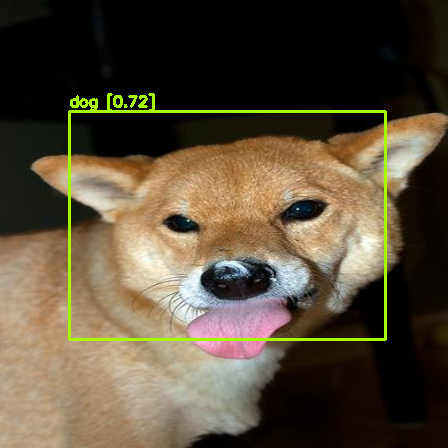

True

In [32]:
""" Visualize the result by drawing predicted bounding box on the input image  """

S=7
B=2
C=2
img_path = '/content/test/shiba_inu_132_jpg.rf.2f1638e1a50cb8b67b96d96ef2461e01.jpg'
image = Image.open(img_path)
image = image.convert("RGB")
image = image.resize((448,448)) 
tran = transforms.ToTensor()
x = tran(image)
x = x.unsqueeze(0)
predictions = model(x.to(DEVICE))
predictions = predictions.reshape(-1, S, S, 5*B + C )
bboxes = tensor_to_boxes(predictions)

batch_size = len(bboxes)
for idx in range(batch_size):
    nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=0.5,
                threshold=0.2
                ) 

img = cv2.imread(img_path)
img = cv2.resize(img, (448,448))
width , height, ch = img.shape
for box in nms_boxes:
    x1 = int(width* (box[2] - box[4]/2))
    x2 = int(width* (box[2] + box[4]/2))
    y1 = int(height* (box[3] - box[5]/2))
    y2 = int(height* (box[3] + box[5]/2))
    label = class_names[int(box[0])]
    confidence = float(box[1]) 
    shape = [x1,y1,x2,y2]
    #draw bounding box and write confidence and text
    cv2.rectangle(img, (x1, y1), (x2, y2), colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                    (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    colors[label], 2)
cv2_imshow(img)


# save image
cv2.imwrite('output.jpg', img)